### Multi-omic Dataset: Latent representation using Autoencoders
- Load Data
- Normalize Data
- Define, Train and Evaluate Classifier: Random Forest
- Define, Train and Evaluate Classifier: XGBoost
- Define, Train and Evaluate Classifier: DNN models
- Evaluation and Conclusions

In [1]:
import numpy as np
import random as rn
import pandas as pd 
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

rn.seed(1)
np.random.seed(1)
tf.random.set_seed(1)
tf.config.threading.set_inter_op_parallelism_threads(1)
tf.config.threading.set_intra_op_parallelism_threads(1)

# Load Data
X_renal_data = pd.read_csv('./x_exp_renal.csv', sep='\t') # Dataset has Donor ID as first column
y_renal_data = pd.read_csv('./y_renal.csv', sep=',') # Dataset has Donor ID on first column and Label on second column.

from sklearn.model_selection import train_test_split
# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_renal_data.iloc[:,1:],y_renal_data["label"],test_size=0.2, random_state=1) # Drop the Donor ID column from both datasets
# Normalization of data sets
# Data Scaling MinMax
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
X_train_norm = X_train
X_test_norm = X_test

X_train_norm = pd.DataFrame(scaler.fit_transform(X_train_norm))
X_test_norm = pd.DataFrame(scaler.transform(X_test_norm))

# We will use "X_train_norm" as training dataset

In [2]:
# Random Forest Classifier 
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.ensemble import RandomForestClassifier
rfc = RandomForestClassifier(random_state=0, class_weight="balanced_subsample") # try class_weights "balanced" and "balanced_subsample"

# Perform CV to tune n_estimators for best RFC fit
params_grid = [{'n_estimators': [110, 120, 140], 'max_depth':[12,13,14]}]

# Perform Cross Validation Grid Search to find best hyperparamters
rfc_grid = GridSearchCV(estimator=rfc, param_grid=params_grid, cv=5)
rfc_grid.fit(X_train_norm, y_train)

# Print training scores
print('Best score for training data:', rfc_grid.best_score_,"\n") 
print('Best #estimators:',rfc_grid.best_estimator_.n_estimators,"\n") 
print('Best max depth:',rfc_grid.best_estimator_.max_depth,"\n") 

# Select the estimator with the best hyperparameters
final_rfc = rfc_grid.best_estimator_

# Predict classification with final model
y_pred = final_rfc.predict(X_test_norm)

cm = confusion_matrix(y_test,y_pred)

print(cm)
print("\n")
print(classification_report(y_test,y_pred))

print("Training set score for RFC: %f" % final_rfc.score(X_train_norm, y_train))
print("Testing  set score for RFC: %f" % final_rfc.score(X_test_norm  , y_test))

# Best performance with Random Forest Classifier: 94%

Best score for training data: 0.976905311778291 

Best #estimators: 140 

Best max depth: 12 

[[77  2]
 [ 1 29]]


              precision    recall  f1-score   support

          -1       0.99      0.97      0.98        79
           1       0.94      0.97      0.95        30

    accuracy                           0.97       109
   macro avg       0.96      0.97      0.97       109
weighted avg       0.97      0.97      0.97       109

Training set score for RFC: 1.000000
Testing  set score for RFC: 0.972477


In [9]:
import xgboost as xgb
y_train_0 = y_train + 1
y_test_0 = y_test + 1
xg_train = xgb.DMatrix(X_train_norm, label=y_train_0)
xg_test = xgb.DMatrix(X_test_norm, label=y_test_0)
# setup parameters for xgboost
param = {}
# use softmax multi-class classification
param['objective'] = 'multi:softmax'
# scale weight of positive examples
param['eta'] = 0.15
param['max_depth'] = 10
param['silent'] = 1
param['nthread'] = 4
param['num_class'] = 3

watchlist = [(xg_train, 'train'), (xg_test, 'test')]
num_round = 15
bst = xgb.train(param, xg_train, num_round, watchlist)
# get prediction
pred = bst.predict(xg_test)
error_rate = np.sum(pred != y_test_0) / y_test_0.shape[0]
print('Test error using softmax = {}'.format(error_rate))

# do the same thing again, but output probabilities
param['objective'] = 'multi:softprob'
bst = xgb.train(param, xg_train, num_round, watchlist)
# Note: this convention has been changed since xgboost-unity
# get prediction, this is in 1D array, need reshape to (ndata, nclass)
pred_prob = bst.predict(xg_test).reshape(y_test_0.shape[0], 3)
pred_label = np.argmax(pred_prob, axis=1)
error_rate = np.sum(pred_label != y_test_0) / y_test_0.shape[0]
print('Test error using softprob = {}'.format(error_rate))

cm = confusion_matrix(y_test_0, pred)

print(cm)
print("\n")
print(classification_report(y_test_0,pred))

print("Testing  set score for XGBoost: %f" % ((y_test_0 == pred).sum() / y_test_0.size) )

[0]	train-merror:0.009238	test-merror:0.036697
[1]	train-merror:0.004619	test-merror:0.036697
[2]	train-merror:0.006928	test-merror:0.027523
[3]	train-merror:0.004619	test-merror:0.027523
[4]	train-merror:0	test-merror:0.027523
[5]	train-merror:0	test-merror:0.027523
[6]	train-merror:0	test-merror:0.027523
[7]	train-merror:0	test-merror:0.027523
[8]	train-merror:0	test-merror:0.027523
[9]	train-merror:0	test-merror:0.027523
[10]	train-merror:0	test-merror:0.027523
[11]	train-merror:0	test-merror:0.027523
[12]	train-merror:0	test-merror:0.027523
[13]	train-merror:0	test-merror:0.027523
[14]	train-merror:0	test-merror:0.027523
[15]	train-merror:0	test-merror:0.027523
[16]	train-merror:0	test-merror:0.027523
[17]	train-merror:0	test-merror:0.027523
[18]	train-merror:0	test-merror:0.027523
[19]	train-merror:0	test-merror:0.027523
[20]	train-merror:0	test-merror:0.027523
[21]	train-merror:0	test-merror:0.027523
[22]	train-merror:0	test-merror:0.027523
[23]	train-merror:0	test-merror:0.02752

In [3]:
# DNN Classifier
# One hot encode labels
from sklearn.preprocessing import LabelEncoder
OH_encoder = LabelEncoder()
OH_y_train = pd.DataFrame(OH_encoder.fit_transform(y_train))
OH_y_test = pd.DataFrame(OH_encoder.transform(y_test))
y_train_oh = keras.utils.to_categorical(OH_y_train)
y_test_oh = keras.utils.to_categorical(OH_y_test)

# Callbacks and plot functions
class PrintDot(keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs):
    if epoch % 100 == 0: print('')
    print('.', end='')

def plot_history(history):
  hist = pd.DataFrame(history.history)
  hist['epoch'] = history.epoch

  plt.figure()
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.plot(hist['epoch'], hist['accuracy'],
           label='Train Accuracy')
  plt.plot(hist['epoch'], hist['val_accuracy'],
           label = 'Val Accuracy')
  plt.legend()

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.0005, patience=10, restore_best_weights=True)
rlrop = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto')

In [12]:
# DNN model for classification
# Define Model 1 - Small "shallow" 1-hidden-layer model
def build_model1(dropout, l1,l2):
  model = keras.Sequential([
    layers.Dense(800, activation=tf.nn.relu,kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=[len(X_train_norm.keys())]),
    layers.Dropout(dropout),
    layers.BatchNormalization(),  
    layers.Dense(200,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
    layers.Dropout(dropout),
    layers.BatchNormalization(),
    layers.Dense(2,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

model = build_model1(0.5,0.0001,0.0001)
EPOCHS = 150
history = model.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop, rlrop,PrintDot()])

plot_history(history)

test_loss, test_acc = model.evaluate(np.array(X_test_norm), y_test_oh, verbose=0)
print(test_loss,test_acc)

Train on 346 samples, validate on 87 samples
Epoch 1/150
346/346 [==============================] - 8s 23ms/sample - loss: 13.6019 - accuracy: 0.8266 - val_loss: 11.8866 - val_accuracy: 0.9655
Epoch 2/150
346/346 [==============================] - 6s 17ms/sample - loss: 11.2069 - accuracy: 0.9075 - val_loss: 10.1633 - val_accuracy: 0.9770
Epoch 3/150
346/346 [==============================] - 6s 18ms/sample - loss: 9.5652 - accuracy: 0.9364 - val_loss: 8.5520 - val_accuracy: 0.9655
Epoch 4/150
346/346 [==============================] - 5s 16ms/sample - loss: 8.0525 - accuracy: 0.9306 - val_loss: 7.1923 - val_accuracy: 0.9655
Epoch 5/150
346/346 [==============================] - 6s 18ms/sample - loss: 6.8087 - accuracy: 0.9422 - val_loss: 6.0880 - val_accuracy: 0.9655
Epoch 6/150
346/346 [==============================] - 5s 16ms/sample - loss: 5.7458 - accuracy: 0.9711 - val_loss: 5.2055 - val_accuracy: 0.9885
Epoch 7/150
346/346 [==============================] - 6s 17ms/sample - los

KeyboardInterrupt: 


..........
Epoch 00011: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
..........
Epoch 00021: ReduceLROnPlateau reducing learning rate to 1.0000000474974514e-05.
109/109 [==============================] - 4s 37ms/sample - loss: 4.4362 - accuracy: 0.7248


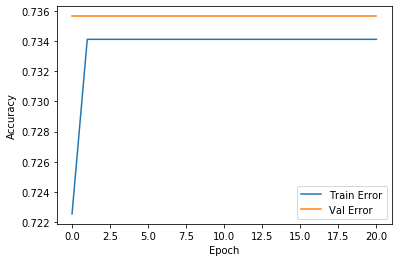

In [15]:
# Define Model 2 - Medium model
def build_model2():
  model = keras.Sequential([
    layers.Dense(8000, activation=tf.nn.relu, input_shape=[len(X_train_norm.keys())]),
    layers.Dense(1000,activation=tf.nn.relu),
    layers.Dense(200,activation=tf.nn.relu),
    layers.Dense(50,activation=tf.nn.relu),
    layers.Dense(2,activation=tf.nn.softmax)
  ])

  optimizer = tf.keras.optimizers.Adam(0.001)

  model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
  return model

model2 = build_model2()
EPOCHS = 1000
history2 = model2.fit(X_train_norm, y_train_oh, epochs=EPOCHS,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, rlrop, PrintDot()])

plot_history(history2)
test_loss2, test_acc2 = model2.evaluate(X_test_norm, y_test_oh)

Train on 346 samples, validate on 87 samples
Epoch 1/100
346/346 [==============================] - 6s 16ms/sample - loss: 16.9324 - accuracy: 0.7717 - val_loss: 14.8274 - val_accuracy: 0.9655
Epoch 2/100
346/346 [==============================] - 4s 11ms/sample - loss: 14.1797 - accuracy: 0.8584 - val_loss: 12.4221 - val_accuracy: 0.9655
Epoch 3/100
346/346 [==============================] - 4s 10ms/sample - loss: 11.9629 - accuracy: 0.8468 - val_loss: 10.6344 - val_accuracy: 0.9655
Epoch 4/100
346/346 [==============================] - 4s 13ms/sample - loss: 10.2913 - accuracy: 0.9017 - val_loss: 9.1330 - val_accuracy: 0.9885
Epoch 5/100
346/346 [==============================] - 4s 11ms/sample - loss: 8.7900 - accuracy: 0.9075 - val_loss: 7.7618 - val_accuracy: 0.9770
Epoch 6/100
346/346 [==============================] - 4s 11ms/sample - loss: 7.5033 - accuracy: 0.9364 - val_loss: 6.6572 - val_accuracy: 0.9770
Epoch 7/100
346/346 [==============================] - 4s 11ms/sample - 

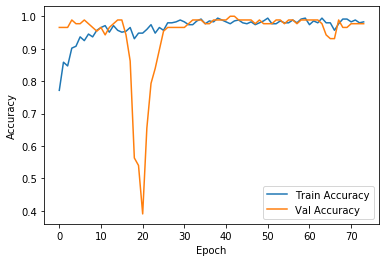

In [5]:
# Define Model 3
def build_model3(dropout: int, l1: int, l2: int):
    model = keras.Sequential([
        layers.Dense(1000, activation=tf.nn.relu ,kernel_regularizer=keras.regularizers.l1_l2(l1,l2), input_shape=[len(X_train_norm.keys())]),
        layers.Dropout(dropout),
        layers.BatchNormalization(),  
        layers.Dense(20,activation=tf.nn.relu, kernel_regularizer=keras.regularizers.l1_l2(l1,l2)),
        layers.Dropout(dropout),
        layers.BatchNormalization(),
        layers.Dense(2,activation=tf.nn.softmax)
  ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='categorical_crossentropy',
                optimizer=optimizer,
                metrics=['accuracy'])
    return model

model3 = build_model3(0.5,0.0001,0.0001)
EPOCHS = 100
history3 = model3.fit(X_train_norm, y_train_oh, epochs=EPOCHS, batch_size=64,
                    validation_split = 0.2, verbose=1, callbacks=[early_stop, rlrop, PrintDot()])

plot_history(history3)
test_loss3, test_acc3 = model3.evaluate(X_test_norm, y_test_oh)

In [ ]:
## Best model: 0.5, 0.0001,0.0001